In [16]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [17]:
'./drive/My Drive/Colab Notebooks/MHK US Equity.xlxs'

'./drive/My Drive/Colab Notebooks/MHK US Equity.xlxs'

In [18]:
df = pd.read_excel(r'./drive/My Drive/Colab Notebooks/MHK US Equity.xlsx')
df_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,DATA,PX_LAST,PX_ASK,PX_BID,NET_INCOME_MARGIN_ADJUSTED,WACC_COST_DEBT,BS_ST_BORROW,BS_LT_BORROW,IS_RD_EXPEND,PX_TO_BOOK_RATIO,IS_INT_EXPENSE,CF_FREE_CASH_FLOW,QUICK_RATIO,CUR_RATIO,WACC,WACC_COST_DEBT.1,WACC_COST_EQUITY,ROC_WACC_RATIO,BEST_NET_DEBT,NET_DEBT_TO_SHRHLDR_EQTY,NET_DEBT_%_CAPITAL,EBITDA,EBIT,BEST_NET_INCOME,EBITDA_TO_REVENUE,EBIT_TO_NET_SALES,BS_TOT_ASSET,SALES_REV_TURN,BEST_EST_PE_CUR_YR,BEST_PE_RATIO,CURR_ENTP_VAL,REVENUE_GROWTH_ADJUSTED_5Y_CAGR,SALES_GROWTH,EBITDA_GROWTH,GEO_GROW_EBITDA,NET_INC_GROWTH,GEO_GROW_NET_INC,BEST_EPS_NXT_YR,MOV_AVG_50D,MOV_AVG_200D,RSI_14D,RSI_30D,RSI_9D,PX_VOLUME
0,2013-12-31,148.90,148.91,148.90,7.0948,3.3894,127.218,2132.79,0,2.4261,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13029.0296,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,138.8840,123.2779,65.1380,65.1935,67.9928,533632
1,2014-01-01,148.90,148.91,148.90,7.0948,3.3894,127.218,2132.79,0,2.4261,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13029.0296,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,138.8840,123.2779,65.1380,65.1935,67.9928,533632
2,2014-01-02,149.11,149.10,149.07,7.0948,3.3894,127.218,2132.79,0,2.4295,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13044.2809,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,139.3660,123.4603,65.4500,65.3393,68.4927,676997
3,2014-01-03,149.45,149.48,149.47,7.0948,3.3894,127.218,2132.79,0,2.4351,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,13068.9733,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,139.8022,123.6346,65.9809,65.5808,69.3643,521291
4,2014-01-06,147.34,147.40,147.36,7.0948,3.3894,127.218,2132.79,0,2.4007,22.148,87.163,0.7979,2.3362,10.9074,3.3894,12.4772,0.58,0,49.3466,33.0416,237.317,150.988,0.0,12.3339,7.8472,8494.177,1924.104,0.0,0.0,12915.7349,0.0,34.0224,48.5664,0.0,42.5703,0.0,0.0,140.1838,123.8148,59.8358,62.7730,58.1367,470527


In [0]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

from __future__ import print_function, division
from tensorflow.contrib import rnn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()

In [20]:
minmax = MinMaxScaler().fit(df.iloc[:, 3:4].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 3:4].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.216807
1,0.216807
2,0.217788
3,0.220095
4,0.207925


In [21]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1434, 44), (1404, 1), (30, 1))

In [0]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.contrib.rnn.BasicRNNCell(size_layer)
        
        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.contrib.rnn.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.contrib.rnn.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [0]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [0]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))
        
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [25]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:58<00:00,  1.26it/s, acc=88.8, cost=0.0287]


simulation 2


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:52<00:00,  1.29it/s, acc=84.9, cost=0.0492]


simulation 3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:51<00:00,  1.30it/s, acc=87.1, cost=0.0367]


simulation 4


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:45<00:00,  1.33it/s, acc=79.9, cost=0.0952]


simulation 5


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:41<00:00,  1.35it/s, acc=86.5, cost=0.0405]


simulation 6


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:44<00:00,  1.34it/s, acc=82.4, cost=0.0694]


simulation 7


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:38<00:00,  1.37it/s, acc=88.3, cost=0.0305]


simulation 8


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:44<00:00,  1.34it/s, acc=87.4, cost=0.0378]


simulation 9


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:47<00:00,  1.32it/s, acc=86.9, cost=0.0375]


simulation 10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [03:43<00:00,  1.34it/s, acc=79, cost=0.106]


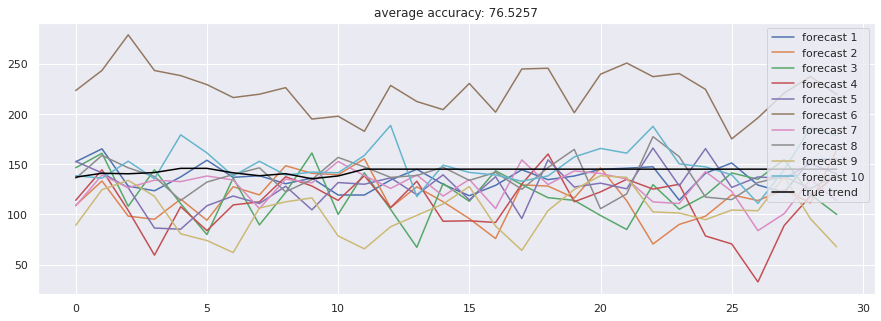

In [26]:
accuracies = [calculate_accuracy(df['PX_LAST'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['PX_LAST'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()